## Credit Card Dataset

### Below are three files that contain the customer’s transaction information and inventories in the credit card information.

a) CDW_SAPP_CUSTOMER.JSON: This file has the existing customer details.

b) CDW_SAPP_CREDITCARD.JSON: This file contains all credit card transaction information.

c) CDW_SAPP_BRANCH.JSON: Each branch’s information and details are recorded in this file.


In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from dotenv import load_dotenv
from pyspark.sql.functions import*
from pyspark.sql.types import StringType, IntegerType, BooleanType, DoubleType
import pandas as pd
import mysql.connector as mariadb
from mysql.connector import Error
import os
import re
import matplotlib.pyplot as plt
import random

## Loading the environment variables

In [4]:
# Loading the .env file
# Loading as environment variable
load_dotenv()
user = os.environ.get("user")
pwd = os.environ.get("pwd")

## Creating the Spark Session

In [5]:
# Creating Spark Session
spark = SparkSession.builder.appName('Capstone').getOrCreate()

### Fetching the customer, branch and the creditcard data from the creditcard_capstone database

In [6]:
# Function to fetch all the creditcard, customer and branch data from the creditcard_capstone database
def get_creditcard_info(user, pwd):
    
# Getting the creditcard transaction data     
    df_transactions=spark.read.format("jdbc")    \
             .options(driver="com.mysql.cj.jdbc.Driver",\
                      user=user,\
                      password=pwd,\
                      url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                      dbtable = "creditcard_capstone.cdw_sapp_credit_card").load()
    
# Getting the customer data
    df_customers=spark.read.format("jdbc")    \
             .options(driver="com.mysql.cj.jdbc.Driver",\
                      user=user,\
                      password=pwd,\
                      url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                      dbtable = "creditcard_capstone.cdw_sapp_customer").load()
    
# Getting the branch data    
    df_branches=spark.read.format("jdbc")    \
             .options(driver="com.mysql.cj.jdbc.Driver",\
                      user=user,\
                      password=pwd,\
                      url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                      dbtable = "creditcard_capstone.cdw_sapp_branch").load()
    
# Returning the creditcard transaction, customer and branch data fetched from the creditcard_capstone database
    return df_transactions, df_customers, df_branches

## Extracting data from the files

In [5]:
# Function to extract the customer, branch and the creditcard data from the files
def extract():
    # Reading the customer json file into the spark dataframe
    df_customer = spark.read.json("json_files/cdw_sapp_custmer.json")

    # Reading the branch json file into the spark dataframe
    df_branch = spark.read.json('json_files/cdw_sapp_branch.json')

    # Reading the credit card json file into the pandas dataframe
    df_creditcard = pd.read_json("json_files/cdw_sapp_credit.json", lines=True)

    # Returning the customer, branch and the creditcard data after reading from thr input file
    return df_customer, df_branch, df_creditcard


## Transforming the data as per the mapping logic

In [22]:
# Function to transform the customer, branch and the creditcard data as per the mapping logic
def transform(df_customer, df_branch, df_creditcard):
# Customer data

    df_customer = df_customer.select(col("SSN").cast("int"), initcap(col("FIRST_NAME")).alias("FIRST_NAME"), lower(col("MIDDLE_NAME")).alias("MIDDLE_NAME"), \
                            initcap(col("LAST_NAME")).alias("LAST_NAME"), col("CREDIT_CARD_NO"), \
                            concat_ws(',', col("APT_NO"), col("STREET_NAME")).alias("FULL_STREET_ADDRESS"), \
                            col("CUST_CITY"), col("CUST_STATE"), col("CUST_COUNTRY"), col("CUST_ZIP").cast("int"), \
                            regexp_replace(col("CUST_PHONE"), r'^(\d{3})(\d{4})$', '(214)$1-$2').alias('CUST_PHONE'), \
                            col("CUST_EMAIL"), col("LAST_UPDATED").cast("timestamp"))

# Branch data

# Creating the temporary view for the branch data
    df_branch.createOrReplaceTempView("branchtable")

# Getting all the records from the branchtable created above and applying the mapping logic
    df_branch = spark.sql("SELECT CAST(BRANCH_CODE AS INT), BRANCH_NAME, BRANCH_STREET, BRANCH_CITY, \
                          BRANCH_STATE, CAST(IF(BRANCH_ZIP IS NULL, '99999', BRANCH_ZIP) AS INT) AS BRANCH_ZIP, \
                          CONCAT('(', SUBSTR(BRANCH_PHONE, 1, 3), ')', SUBSTR(BRANCH_PHONE, 4,3), '-', SUBSTR(BRANCH_PHONE, 7, 4)) AS BRANCH_PHONE, \
                          CAST(LAST_UPDATED AS TIMESTAMP) FROM BRANCHTABLE")


# Creditcard data

# Converting the data types and renaming the columns as per the mapping logic
    df_creditcard = df_creditcard.astype({"DAY":'str',"MONTH":'str',"YEAR":'str', "CREDIT_CARD_NO":'str'})
    df_creditcard.rename(columns={"CREDIT_CARD_NO" : "CUST_CC_NO"}, inplace=True)
    df_creditcard['DAY'] = df_creditcard['DAY'].str.zfill(2)
    df_creditcard['MONTH'] = df_creditcard['MONTH'].str.zfill(2)    

# Combining the day, month and year to form the TIMEID
    df_creditcard['TIMEID'] = df_creditcard['YEAR'] + df_creditcard['MONTH'] + df_creditcard['DAY']

# Dropping the Day, Month and Year columns from the creditcard data
    df_creditcard.drop(columns=['DAY', 'MONTH', 'YEAR'], axis = 1, inplace = True)

# Converting the credit card pandas dataframe into spark dataframe
    df_creditcard = spark.createDataFrame(df_creditcard)

# Converting the columns Branch Code, Cust SSN, Transaction ID to the interger data type
    df_creditcard= df_creditcard.withColumn("BRANCH_CODE", df_creditcard["BRANCH_CODE"].cast("int"))
    df_creditcard = df_creditcard.withColumn("CUST_SSN", df_creditcard["CUST_SSN"].cast("int"))
    df_creditcard = df_creditcard.withColumn("TRANSACTION_ID", df_creditcard["TRANSACTION_ID"].cast("int"))

    # Return the transformed customer, branch abd creditcard data
    return df_customer, df_branch, df_creditcard

## Loading the data into the database

In [23]:
# Function to load the customer, branch and the creditcard data to the database creditcard_capstone
def load(df_customer_data, df_branch_data, df_creditcard_data):
    # Writing the customer data to the customer database table
    df_customer_data.write.format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate", "true") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("createTableColumnTypes", "FIRST_NAME VARCHAR(30), MIDDLE_NAME VARCHAR(30), \
                    LAST_NAME VARCHAR(30), CREDIT_CARD_NO VARCHAR(20), FULL_STREET_ADDRESS VARCHAR(50), \
                    CUST_CITY VARCHAR(30), CUST_STATE VARCHAR(5), CUST_COUNTRY VARCHAR(30), \
                    CUST_PHONE VARCHAR(20), CUST_EMAIL VARCHAR(30)") \
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
                    .option("user", user) \
                    .option("password", pwd) \
                    .save()

# Writing the branch data to the branch database table
    df_branch_data.write.format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate", "true") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("createTableColumnTypes", "BRANCH_NAME VARCHAR(30), BRANCH_STREET VARCHAR(50), \
                     BRANCH_CITY VARCHAR(30), BRANCH_STATE VARCHAR(5       ), BRANCH_PHONE VARCHAR(20)") \
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
                    .option("user", user) \
                    .option("password", pwd) \
                    .save()


# Writing the creditcard data to the creditcard database table
    df_creditcard_data.write.format("jdbc") \
                    .mode("overwrite") \
                    .option("truncate", "true") \
                    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
                    .option("createTableColumnTypes", "CUST_CC_NO VARCHAR(20), TIMEID VARCHAR(10), \
                    TRANSACTION_TYPE VARCHAR(30)") \
                    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
                    .option("user", user) \
                    .option("password", pwd) \
                    .save()


## Displaying Schema

In [24]:
# Function to print the schema in a tree structure for the dataframe data provided
def print_schema(df):
    df.printSchema()
    return ""
   

## Displaying data types

In [25]:
# Function to print the data types of the columns in the dataframe for the given data
def print_data_types(df):
    print(df.dtypes)
    return ""
      

## Displaying the customer, branch and creditcard data

In [26]:
# Function to display the records with all the information 
def display_data(df_type):
    df_type.show(5)
    return ""


## Extract, Transform and Load (ETL)

In [27]:
def extract_transform_load():    

# Extract, transform and load data to the creditcard_capstone database

    # Extract
    print("Extraction started")

    # Extract the customer, branch and creditcard transaction data
    df_customer, df_branch, df_creditcard = extract()

    print("\nExtraction completed")

    # Transform
    print("\nTransform started")

    # Transform the customer, branch and the creditcard transaction data
    df_customer_data, df_branch_data, df_creditcard_data = transform(df_customer, df_branch, df_creditcard)

    print("\nTransform completed")

    # Displaying the schemas after transformation
    print("\nDisplaying the schema after transformation")
    print("\nCustomer schema after transformation:")
    print_schema(df_customer_data)
    print("\nBranch schema after transformation:")
    print(print_schema(df_branch_data))
    print("\nCreditcard schema after transformation:")
    print(print_data_types(df_creditcard_data))

    # Displaying the customer, branch and creditcard transaction data after transformation
    # and before loading it to the creditcard_capstone database
    print("\nDisplaying the data before loading to the database")
    
    # Displaying customer data
    print("\nCustomer data:")
    display_data(df_customer_data)

    # Displaying the branch data
    print("\nBranch data:")
    display_data(df_branch_data)

    # Displaying the creditcard data
    print("\nCreditcard data:")
    display_data(df_creditcard_data)

    # Loading
    print("\nLoading started")

    # Load the customer, branch and the creditcard transaction data
    load(df_customer_data, df_branch_data, df_creditcard_data)
    
    print("\nLoading completed")    

## Business Requirements - ETL

## 1. Functional Requirements - Load Credit Card Database (SQL)

### Req-1.1 Data Extraction and Transformation with Python and PySpark

Functional Requirement 1.1

a) For “Credit Card System,” create a Python and PySpark SQL
program to read/extract the following JSON files according 
to the specifications found in the mapping document.
1. CDW_SAPP_BRANCH.JSON
2. CDW_SAPP_CREDITCARD.JSON
3. CDW_SAPP_CUSTOMER.JSON

Note: Data Engineers will be required to transform the data based on the
requirements found in the Mapping Document.

Hint: [You can use PYSQL “select statement query” or simple Pyspark
RDD].

### Req-1.2 Data loading into Database

### Function Requirement 1.2

Once PySpark reads data from JSON files, and then utilizes Python,
PySpark, and Python modules to load data into RDBMS(SQL), perform
the following:

a) Create a Database in SQL(MariaDB), named
“creditcard_capstone.”

b) Create a Python and Pyspark Program to load/write the “Credit
Card System Data” into RDBMS(creditcard_capstone).

Tables should be created by the following names in RDBMS:

CDW_SAPP_BRANCH

CDW_SAPP_CREDIT_CARD

CDW_SAPP_CUSTOMER

In [28]:
# Checking if the customer, branch and creditcard table exists in the creditcard_capstone database.
# Extract, transform and load the customer, branch and creditcard data only if table does not exists in the database.
df_table=spark.read.format("jdbc")    \
             .options(driver="com.mysql.cj.jdbc.Driver",\
                      user=user,\
                      password=pwd,\
                      url="jdbc:mysql://localhost:3306/creditcard_capstone",\
                      dbtable = "information_schema.tables").load().filter("table_schema = 'creditcard_capstone'")
# Check whether any record is there in the database
if df_table.isEmpty():
    try:
        extract_transform_load()
    except Error as e:
        print("Error Message:", e)

## 2. Functional Requirements - Application Front-End

Once data is loaded into the database, we need a front-end (console) to see/display data. For
that, create a console-based Python program to satisfy System Requirements 2 (2.1 and 2.2).

## 2.1 Transaction Details Module

### Req-2.1 Transaction Details Module

### Functional Requirements 2.1 


#### 1) Used to display the transactions made by customers living in a given zip code for a given month and year. 
#### Order by day in descending order.

In [7]:
# Fetching all the creditcard transaction, customer and branch data from the creditcard_capstone database.
df_transactions, df_customers, df_branches = get_creditcard_info(user, pwd)

# Creating a temporary view for the creditcard transaction data.
df_transactions.createOrReplaceTempView("creditview")

# Creating a temporary view for the customer data.
df_customers.createOrReplaceTempView("customerview")

# Creating a temporary view for the branch data.
df_branches.createOrReplaceTempView("branchview")

In [9]:
# Function to get the transaction data into pandas dataframe.
#def get_transaction_data_into_pandas_dataframe():
#get_creditcard_info(user, pwd)    
    # Transaction data
df_tran = df_transactions.toPandas()
    
    # Customer data
df_cus = df_customers.toPandas()
    
    # Branch data
df_br = df_branches.toPandas()

# Getting the credit card transactions for customers
df_customer_cc = pd.merge(df_cus, df_tran, how='inner', left_on='CREDIT_CARD_NO', right_on='CUST_CC_NO')

# Getting the transctions for branches
df_branch_cc = pd.merge(df_br, df_tran,  how='inner', on='BRANCH_CODE')

# Getting the list of columns to be displayed for modification
customer_columns = df_cus.columns.tolist()
customer_columns.remove('LAST_UPDATED')
customer_columns.remove('SSN')
customer_columns.remove('CREDIT_CARD_NO')
customer_columns.remove('CUST_COUNTRY')
customer_columns.remove('FIRST_NAME')
customer_columns.remove('LAST_NAME')
customer_columns.remove('MIDDLE_NAME')


C:\spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
C:\spark\python\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


### Function to validate month.

In [61]:
# Function to validate month
def validate_month():

    # Validating the month.
    while True:

        # Getting the month as input.
        month = input("\nEnter the month in 2 digits: ")
        month = month.strip()

        # Checking whether the month contains only numbers.
        if month.isdigit() and len(month) == 2 and month != '00':

            # Checking whether the month is in the range of 0 to 12.
            if int(month.lstrip('0')) in range(0,13):
                # If the month is only numbers and in the range of 1 and 12 then it is a valid month.
                print('\nValid month')
                break
            else:
                # If the month is not in the range of 1 and 12 then it is an invalid year.
                print("\nInvalid month. Try Again.") 
        else:
            # If the month does not have only numbers then it is an invalid month.
            print("\nInvalid entry. Try Again.")    

    return month


### Function to validate day.

In [158]:
# Function to validate day
def validate_day():
    # Validating the endday.
    while True:

        # Getting the endday as input.
        day = input('\nEnter day in 2 digits: ')
        day = day.strip()

        # If the day has only numbers and is of length 2 and not equal to zero.
        if day.isdigit() and len(day) == 2 and day != '00':
            # If the day is between 1 and 31 then it is valid.
            if int(day.lstrip('0')) in range(0,32):
                print('Valid day\n')
                break
            else:
                # If the day is not between 1 and 31 then the day is invalid.
                print('\nInvalid day. Try again.')
        else:
            # If the day does not have only numbers and not of length 2 and is equal to zero then the day is invalid.
            print('\nInvalid entry. Try again.')

    return day

### Function to validate year.

In [66]:
# Function to validate year
def validate_year():
    # Validating the year.
    while True:
         
        # Getting the year as input.
        year = input("\nEnter the year in 4 digits: ")
        year = year.strip()
       
        # Checking whether the year contains only numbers and is of length 4.
        if year.isdigit() and len(year) == 4:
            # If year is a number and has 4 digits then it is a valid year.
            print('\nValid year')
            year = int(year)
            break   
        else:
            # If the year does not have only numbers then it is an invalid year.
            print("\nInvalid year. Try Again.")
            
    return year

### Function to validate zipcode.

In [84]:
# Function to validate zipcode.
def validate_zipcode():   

     # Validating the zipcode.
   while True:

        # Getting the zipcode as input.
        zipcode = input("\nEnter the ZIP code in 5 digits: ")
        zipcode = zipcode.strip()

        # Checking if the zipcode has only numbers and is of length 5.
        if zipcode.isdigit() and len(zipcode) == 5:
           zipcode = int(zipcode)
           # If the zipcode has only numbers and is of length 5 then it is a valid zipcode.
           print('Valid zipcode')
           break
        else:
           # If the zipcode does not have only numbers then it is a invalid zipcode.
           print('\nInvalid entry. Try again.')

   return zipcode

### Function to display the transactions made by customers living in a given zip code for a given month and year. 
### Order by day in descending order.

In [73]:
# Transaction module

# Function to display the transactions made by customers living in a
# given zip code for a given month and year. Order by day in
# descending order.

def transaction_customer_for_zip_month_year():

    # Validating the zipcode.
    zipcode = validate_zipcode()
    
    # Validating the month.
    month = validate_month()
    
    # Validating the year.
    year = validate_year()

    # Fetching the records from the creditview and customerview 
    # to display the transactions made by customers living in a
    # given zip code for a given month and year. Order by day in
    # descending order.
    df_result = spark.sql("SELECT \
    REPLACE(CR.CUST_CC_NO, SUBSTR(CR.CUST_CC_NO, 1, 12), '************') AS CUSTOMER_CREDIT_CARD_NO, \
    CR.TIMEID, CR.BRANCH_CODE, CR.TRANSACTION_TYPE, CR.TRANSACTION_VALUE, CR.TRANSACTION_ID \
    FROM CREDITVIEW AS CR \
    JOIN CUSTOMERVIEW AS CU \
    ON CR.CUST_CC_NO = CU.CREDIT_CARD_NO \
    WHERE CU.CUST_ZIP = {} \
    AND  MONTH(TO_DATE(CR.TIMEID, 'yyyyMMdd')) = '{}' \
    AND  YEAR(TO_DATE(CR.TIMEID, 'yyyyMMdd')) = '{}' \
    ORDER BY DAY(TO_DATE(CR.TIMEID, 'yyyyMMdd')) DESC".format(zipcode, month, year))


# Displaying the customer transaction details.
    if df_result.isEmpty():
        print('\nNo data matching criteria.')

    df_result.show()


In [69]:
# Function to display the transactions made by customers living in a
# given zip code for a given month and year. Order by day in
# descending order.

transaction_customer_for_zip_month_year()

Valid zipcode

Valid month

Valid year
+-----------------------+--------+-----------+----------------+-----------------+--------------+
|CUSTOMER_CREDIT_CARD_NO|  TIMEID|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+-----------------------+--------+-----------+----------------+-----------------+--------------+
|       ************7473|20180828|         93|       Education|            43.44|         12654|
|       ************7310|20180828|        124|         Grocery|            59.07|          3544|
|       ************9197|20180827|         53|       Education|            16.82|         15818|
|       ************7473|20180827|         73|            Test|            66.43|         12657|
|       ************7310|20180827|        164|         Grocery|            97.12|          3547|
|       ************9363|20180825|         42|             Gas|            98.24|         15191|
|       ************8802|20180825|        114|   Entertainment|            65.93|       

#### 2) Used to display the number and total values of transactions for a given type.


### Function to display the number and total values of transactions for a given transaction type.

In [101]:
# Function to display the number and total values of transactions for a given transaction type.
def number_and_total_values_of_transactions():

    # Getting the unique transaction types from the creditview.
    tran_type = spark.sql("SELECT DISTINCT TRANSACTION_TYPE FROM CREDITVIEW")
    # Converting it to Pandas dataframe to have it as a list to validate. 
    df_tran = tran_type.toPandas()
    # Getting the unique values of the transaction type as a list.
    tran_type = pd.unique(df_tran['TRANSACTION_TYPE'])


    # Validating the Transaction type.
    while True:

        # Getting the transaction type as input.
        transaction_type = input("\nEnter Transaction Type: ")
        transaction_type = transaction_type.strip()

        # Validating whether the entered transaction type exists in the database.
        if transaction_type.title() in tran_type:
        # If exists then it is a valid transaction type.
            print("\nValid transaction type\n")
            break
        else:
        # If the transaction type does not exists in the database then it is not a valid one.
            print("\nNo transaction type found. Try Again")

    # Displaying the number and total values of transactions for a given transaction type.
    df_result = spark.sql("SELECT TRANSACTION_TYPE, COUNT(TRANSACTION_ID) AS NUMBER_OF_TRANSACTIONS, \
    SUM(TRANSACTION_VALUE) AS TRANSACTION_VALUE FROM CREDITVIEW \
    WHERE TRANSACTION_TYPE = '{}' \
    GROUP BY TRANSACTION_TYPE".format(transaction_type))


    # Displaying the transaction details for a given transaction type.
    if df_result.isEmpty():
        print('\nNo data matching criteria.')

    df_result.show()

In [102]:
# Function to display the number and total values of transactions for a given transaction type.
number_and_total_values_of_transactions()


Valid transaction type

+----------------+----------------------+-----------------+
|TRANSACTION_TYPE|NUMBER_OF_TRANSACTIONS|TRANSACTION_VALUE|
+----------------+----------------------+-----------------+
|      Healthcare|                  6723|340476.1999999999|
+----------------+----------------------+-----------------+



#### 3) Used to display the number and total values of transactions for branches in a given state.

### Function to display the number and total values of transactions for branches in a given state.

In [142]:
# Function to display the number and total values of transactions for branches in a given state.
def number_and_total_transaction_values_for_branches():

    # Getting the unique states from the branchview.  
    br_state = spark.sql("SELECT DISTINCT BRANCH_STATE FROM BRANCHVIEW")
    # Converting it to Pandas dataframe to have it as a list to validate.
    df_state = br_state.toPandas()
    # Getting the unique values of the state as a list.
    branch_states = pd.unique(df_state['BRANCH_STATE'])
    

    # Validating the State
    while True:
        # Getting the state as input.
        state = input('\nEnter state in 2 letters: ')
        # Removing the leading and trailing spaces.
        state = state.strip().upper()

        # Checking whether the state has only letters and the length is 2.
        if state.isalpha() and len(state) == 2:
            # Converting the state to upper case.
            if state in branch_states:
            # If the State exists in the database then it is a valid state.
                print('\nBranch(es) found for given state')
                break
            else:
                # If State does not exist then no branches exist.
                print('\nNo branches found. Try again.')
        else:
            # If the State entered does not have only letters or not of length 2 then it
            # is not a valid State.
            print('\nInvalid entry. Try again.')


    # Display the number and total values of transactions for
    # branches in a given state.
    df_result = spark.sql("SELECT B.BRANCH_CODE, COUNT(C.TRANSACTION_ID) AS NUMBER_OF_TRANSACTIONS, \
    SUM(C.TRANSACTION_VALUE) AS TRANSACTION_VALUE \
    FROM BRANCHVIEW AS B \
    JOIN CREDITVIEW AS C ON B.BRANCH_CODE = C.BRANCH_CODE \
    WHERE B.BRANCH_STATE ='{}' \
    GROUP BY B.BRANCH_CODE".format(state))

    print("\nThe number and total values of transactions for branches in the State {}:".format(state))

    # Displaying the transactions for the branches.
    if df_result.isEmpty():
        print('\nNo data matching criteria.')
        
    df_result.show()

In [143]:
# Function to display the number and total values of transactions for branches in a given state.
number_and_total_transaction_values_for_branches()


Branch(es) found for given state

The number and total values of transactions for branches in the State MN:
+-----------+----------------------+------------------+
|BRANCH_CODE|NUMBER_OF_TRANSACTIONS| TRANSACTION_VALUE|
+-----------+----------------------+------------------+
|          1|                   374|18157.570000000007|
|         20|                   381|19350.830000000034|
|        124|                   372|18644.889999999992|
+-----------+----------------------+------------------+



## 2.2 Customer Details Module

### Req-2.2 Customer Details

### Functional Requirements 2.2



#### 1) Used to check the existing account details of a customer.


## Function to check the existing account details of a customer.

### Function to validate credit card number.

In [78]:
def validate_credit_card_no():
    # Validating the credit card number.
    while True:
        cardno = input("\nEnter the 16 digit Credit Card Number: ")
        cardno = cardno.strip()

        # Checking the creditcard number has only numbers in it and is of length 16.
        if cardno.isdigit() and len(cardno) == 16:
            # If the creditcard number has only numbers and is of length 16 then it is a valid number.
            print("Valid Credit Card Number\n")
            break
        else:
            # If the credit card does not have only the numbers or not of length 16 then invalid.
            print('\nInvalid entry. Try again.')

    return cardno

### Function to validate phone number.

In [163]:
# Function to validate phone number.
def validate_phone():
    while True: 
        new_entry = input('\nEnter new phone number in 10 digits: ')
        new_entry = new_entry.strip()
        if new_entry.isdigit() and len(new_entry) == 10:
            print("Valid Phone Number\n")
            new_entry = '(' + new_entry[:3] + ')' + new_entry[3:6] + '-' + new_entry[6:]
            break
                         
        else:
            print('\nInvalid entry. Try again.')

    return new_entry        


#### 1) Used to check the existing account details of a customer.


In [175]:
# Customer Module

# Function to check the existing account details of a customer.
def check_customer_account_details():
    
    # Validating the credit card number.
    cardno = validate_credit_card_no()
    
   # Fetching the existing account details of a customer from the customer table
    df_result = spark.sql(f"SELECT FIRST_NAME, MIDDLE_NAME, LAST_NAME, \
    REPLACE(CREDIT_CARD_NO, SUBSTR(CREDIT_CARD_NO, 1, 12), '************') AS CREDIT_CARD_NO, \
    FULL_STREET_ADDRESS, CUST_CITY, CUST_STATE, CUST_COUNTRY, CUST_ZIP, \
    CUST_PHONE, CUST_EMAIL, LAST_UPDATED \
    FROM CUSTOMERVIEW WHERE CREDIT_CARD_NO = '{cardno}'")
    
                          
    if df_result.isEmpty():
        print('\nNo data matching criteria.')

    # Displaying the existing account details of a customer from the customer table
    df_result.show(5)

In [177]:
# Function to check the existing account details of a customer.
check_customer_account_details()

Valid Credit Card Number

+----------+-----------+---------+----------------+-------------------+---------+----------+-------------+--------+-------------+--------------+-------------------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|  CREDIT_CARD_NO|FULL_STREET_ADDRESS|CUST_CITY|CUST_STATE| CUST_COUNTRY|CUST_ZIP|   CUST_PHONE|    CUST_EMAIL|       LAST_UPDATED|
+----------+-----------+---------+----------------+-------------------+---------+----------+-------------+--------+-------------+--------------+-------------------+
|      Alec|         wm|   Hooper|************1055|   810,Maple Street|   Vienna|        VA|United States|   75987|(214)678-5234|ALucy@test.com|2023-02-24 02:25:40|
+----------+-----------+---------+----------------+-------------------+---------+----------+-------------+--------+-------------+--------------+-------------------+



#### 2) Used to modify the existing account details of a customer.

### Function to validate email.

In [77]:
# Function to validate the email.
def valid_email(email):
    pattern = '^[a-zA-Z0-9-_]+@[a-zA-Z0-9]+\.[a-z]{1,3}$'
    if re.match(pattern, email):
        return True
    else:
        return False

### Function to modify the existing account details of a customer.

In [164]:
# Function to modify the existing account details of a customer.
def modify_existing_account_details_of_a_customer(customer_columns, user, pwd):
  
    # Validating the credit card number.
    cardno = validate_credit_card_no()

    # Connecting to the mysql database.
    try:
        mydb = mariadb.connect(host='localhost',
                                    user=user,
                                    password=pwd,
                                    database='creditcard_capstone')
        # checking whether the database is connected.
        if mydb.is_connected():
            db_Info = mydb.get_server_info()
            mycursor = mydb.cursor()

            # Checking whether the customer record dxists in the customer table for the given credit card number.
            st ="SELECT * FROM CDW_SAPP_CUSTOMER WHERE CREDIT_CARD_NO = '{}'"
            mycursor.execute(st.format(cardno))
            result= mycursor.fetchall()
           
            # If a customer record exists for the given credit card number then allow to modify.
            if len(result) == 0:
               print('No customer record exists in the database for the given credit card number')
            
            else:
                # Populating the dictionary with the selected record record details from the database. 
                cus_data = {}
                cus_data['CREDIT_CARD_NO'] = result[0][4]
                cus_data['FULL_STREET_ADDRESS'] = result[0][5]
                cus_data['CUST_CITY'] = result[0][6]
                cus_data['CUST_STATE'] = result[0][7]
                cus_data['CUST_COUNTRY'] = result[0][8]
                cus_data['CUST_ZIP'] = result[0][9]
                cus_data['CUST_PHONE'] = result[0][10]
                cus_data['CUST_EMAIL'] = result[0][11]
                cus_data['COUNT'] = 0
                count = 1
                
                # Display the menu of customer fields to be modified. 
                for c in customer_columns:
                    print(' ' + str(count) + ') ' + c)
                    count += 1
                print(' ' + str(count) + ') Exit options')
                
                while True:
                    print('\nWhat account detail would you like to modify?')
                    option = input('Enter option: ')
                    option = option.strip()
                    if option.isdigit():
                        if int(option) <= len(customer_columns):
                            column_name = customer_columns[int(option)-1]
                            if option == '1': # FULL_STREET_ADDRESS
                                 while True: 
                                    new_entry = input('\nEnter new ' + column_name + ': ')
                                    new_entry = new_entry.strip()
                                    if re.match(r"\d+,(?:[A-Za-z0-9.-]+[ ]?)+(?:Avenue|Lane|Road|Boulevard|Drive|Street|Ave|Dr|Rd|Blvd|Ln|St)\.?", new_entry):
                                        cus_data['FULL_STREET_ADDRESS'] = new_entry 
                                        cus_data['COUNT'] += 1  
                                        break
                                    else:
                                        print('\nInvalid entry. Try again.')
                                    
                            elif option == '2': # CUST_CITY
                                while True: 
                                    new_entry = input('\nEnter new ' + column_name + ': ')
                                    new_entry = new_entry.strip().title()
                                    if new_entry.isalpha():
                                       cus_data['CUST_CITY'] = new_entry
                                       cus_data['COUNT'] += 1  
                                       break
                                    else:
                                        print('\nInvalid entry. Use only letters. Try again.')

                            elif option == '3': # CUST_STATE
                                while True:
                                    new_entry = input('\nEnter new ' + column_name + ' in 2 letters: ')
                                    new_entry = new_entry.strip().upper()
                                    if new_entry.isalpha() and len(new_entry) == 2:
                                       cus_data['CUST_STATE'] = new_entry
                                       cus_data['COUNT'] += 1  
                                       break
                                    else:
                                        print('\nInvalid entry. Try again.')

                            elif option == '4': # CUST_ZIP
                                  
                                  new_entry = validate_zipcode()
                                  cus_data['CUST_ZIP'] = int(new_entry)
                                  cus_data['COUNT'] += 1  
                      
                            elif option == '5': # CUST_PHONE
                                
                                new_entry = validate_phone()
                                cus_data['CUST_PHONE'] = new_entry
                                cus_data['COUNT'] += 1  
                         
                            elif option == '6': # CUST_EMAIL
                                while True: 
                                    new_entry = input('\nEnter new ' + column_name + '. Follow format abc@test.com: ')
                                    new_entry = new_entry.strip()
                                    if valid_email(new_entry):
                                       cus_data['CUST_EMAIL'] = new_entry
                                       cus_data['COUNT'] += 1  
                                       break
                                    else:
                                        print('\nInvalid email. Try again.')
                        # Exit
                        elif int(option) == count:
                            print('Exited')
                            break
                        else:
                            print('\nInvalid option. Try again.')
                    else:
                        print('\nInvalid option. Try again.')

                # Checking the count to see if any field has been modified.
                if cus_data['COUNT'] > 0:
                               
                    # Update the database with the fields modified.
                    updatest= f"UPDATE CDW_SAPP_CUSTOMER \
                    SET FULL_STREET_ADDRESS= '{cus_data['FULL_STREET_ADDRESS']}', \
                    CUST_CITY= '{cus_data['CUST_CITY']}',CUST_STATE = '{cus_data['CUST_STATE']}', \
                    CUST_ZIP= {cus_data['CUST_ZIP']}, CUST_PHONE= '{cus_data['CUST_PHONE']}', \
                    CUST_EMAIL= '{cus_data['CUST_EMAIL']}', LAST_UPDATED= NOW() \
                    WHERE CREDIT_CARD_NO = '{cus_data['CREDIT_CARD_NO']}'"

                    # Modifying the database.
                    mycursor.execute(updatest)
                    # Save it to the database.
                    mydb.commit()
                                
                    # Checking if there are any records that got updated.
                    if mycursor.rowcount > 0:
                        print('Customer record modified in the database for the given credit card number ending with {}.'.format(cardno[12:16]))
                    else:
                        print('No Customer record modified in the database for the given credit card number ending with {}.'.format(cardno[12:16])) 

    
    # Getting the error           
    except Error as e:
        print("Error while connecting to Database", e)
    
    finally:

        if mydb.is_connected():
            mycursor.close()
            mydb.close()
        

In [165]:
# Function to modify the existing account details of a customer.
modify_existing_account_details_of_a_customer(customer_columns, user, pwd)

Valid Credit Card Number

 1) FULL_STREET_ADDRESS
 2) CUST_CITY
 3) CUST_STATE
 4) CUST_ZIP
 5) CUST_PHONE
 6) CUST_EMAIL
 7) Exit options

What account detail would you like to modify?

Invalid entry. Try again.
Valid Phone Number


What account detail would you like to modify?
Exited
Customer record modified in the database for the given credit card number ending with 1055.


#### 3) Used to generate a monthly bill for a credit card number for a given month and year.


### Function to generate a monthly bill for a credit card number for a given month and year.

In [150]:
# Function to generate a monthly bill for a credit card number for a given month and year.
def credit_card_monthly_bill_for_a_month_and_year():

    # Validating the credit card number.
    cardno = validate_credit_card_no()
        
    # Validating the month.
    month = validate_month()
    
    # Validating the year.   
    year = validate_year()
   
    #  Fetching the customer transaction data for a credit card number for a
    # given month and year.
    df_result = spark.sql(f"SELECT REPLACE(CUST_CC_NO, SUBSTR(CUST_CC_NO, 1, 12), ('************')) AS CUST_CC_NO, \
    SUM(TRANSACTION_VALUE) AS TOTAL_TRANSACTION_VALUE \
    FROM CREDITVIEW WHERE CUST_CC_NO = '{cardno}' AND MONTH(TO_DATE(TIMEID, 'yyyyMMdd')) = '{month}' \
    AND YEAR(TO_DATE(TIMEID, 'yyyyMMdd')) = '{year}' \
    GROUP BY CUST_CC_NO")

    if df_result.isEmpty():
        print('\nNo data matching criteria.')

    # Displaying the credit card transaction details for a
    # given month and year.

    df_result.show()

In [151]:
# Function to generate a monthly bill for a credit card number for a given month and year. 
credit_card_monthly_bill_for_a_month_and_year()


Valid Credit Card Number


Valid month

Valid year
+----------------+-----------------------+
|      CUST_CC_NO|TOTAL_TRANSACTION_VALUE|
+----------------+-----------------------+
|************1055|                  94.88|
+----------------+-----------------------+



#### 4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.


In [170]:
# Function to display the transactions made by a customer between two dates.
# Order by year, month and day in descending order.

def transactions_by_a_customer_between_dates():

    # Validating the credit card number.
    cardno = validate_credit_card_no()

    # Validating the startday.
    startday = validate_day()

    # Validating the startmonth.
    startmonth = validate_month()
        
    # Validating the startyear.
    startyear = validate_year()

    # Validating the endday.
    endday = validate_day()
  
    # Validating the endmonth.
    endmonth = validate_month()
        
    # Validating the endyear.
    endyear = validate_year()
  
    # Convatenating the year, month and day to get the timeid.
    startyear = str(startyear)
    endyear = str(endyear)
    starttimeid = startyear + startmonth + startday
    endtimeid = endyear + endmonth + endday
    
    # Fetching the records to display the transactions made by a customer between
    # two dates. Order by year, month, and day in descending order.

    df_result = spark.sql(f"SELECT REPLACE(CUST_CC_NO, SUBSTR(CUST_CC_NO,1, 12), '************')  AS CUST_CC_NO, \
    TIMEID, BRANCH_CODE, TRANSACTION_TYPE, TRANSACTION_VALUE, \
    TRANSACTION_ID FROM CREDITVIEW \
    WHERE CUST_CC_NO = '{cardno}' AND (TIMEID >= '{starttimeid}' \
    AND TIMEID <= '{endtimeid}') \
    ORDER BY YEAR(TO_DATE(TIMEID, 'yyyyMMdd')) DESC, MONTH(TO_DATE(TIMEID, 'yyyyMMdd')) DESC, DAY(TO_DATE(TIMEID, 'yyyyMMdd')) DESC")


    if df_result.isEmpty():
        print('\nNo data matching criteria.')

    # displaying the transactions made by a customer between
    # two dates. Order by year, month, and day in descending order.

    df_result.show()
    

In [169]:
# Display the transactions made by a customer between
# two dates. Order by year, month, and day in descending order.

transactions_by_a_customer_between_dates()


Valid Credit Card Number

Valid day


Valid month

Valid year
Valid day


Valid month

Valid year
+----------------+--------+-----------+----------------+-----------------+--------------+
|      CUST_CC_NO|  TIMEID|BRANCH_CODE|TRANSACTION_TYPE|TRANSACTION_VALUE|TRANSACTION_ID|
+----------------+--------+-----------+----------------+-----------------+--------------+
|************1055|20180807|        180|           Bills|            34.59|         20565|
|************1055|20180716|         95|       Education|            36.88|         20544|
|************1055|20180714|         46|         Grocery|             42.7|         20547|
|************1055|20180701|        145|             Gas|             80.3|         20529|
|************1055|20180619|         52|   Entertainment|            81.94|         20534|
|************1055|20180611|          8|            Test|            26.96|         20532|
|************1055|20180607|         93|         Grocery|            42.57|         20531|
|*

## 3 - Functional Requirements - Data analysis and Visualization


## Req - 3  Data Analysis and Visualization


### Functional Requirements 3.1

### Find and plot which transaction type has a high rate of transactions.

### Note: Take a screenshot of the graphs

### Function to get random colors for the graph.

In [178]:
# Function to set colors for the plot.
def set_colors_for_plot(length):
    return ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(length)]

### Function to display the transaction types that has the a high rate of transactions.

In [179]:
# Function to plot which transaction type has a high rate of transactions.
def high_rate_of_tran_by_tran_type(df_tran): 
   
    # Getting the count of the number of trsnsactions per transaction type.
    types = df_tran['TRANSACTION_TYPE'].value_counts()

    # Setting the number of colors to the count of the records taken above
    no_of_colors = set_colors_for_plot(len(types))
    types.sort_values(ascending=True, inplace = True)

    # Plotting the transaction type that has a high rate of transactions.
    types.plot(kind='barh', figsize=(10, 5),  xlim=(types.min()-500, types.max()+100), color = no_of_colors)
 
    # Setting the title of the plot.
    plt.title('Total Transactions Per Transaction Type', fontweight = 'bold', fontsize = 18)
    # Setting the x-label.
    plt.xlabel('Rate of Transactions', fontweight = 'bold', fontsize = 14)
    # Setting the y-label.
    plt.ylabel('Transaction Types', fontweight = 'bold', fontsize = 14)

    # annotate value labels to each country.
    for index, value in enumerate(types): 
        plt.text(value+10, index-0.1, str(value))
           
    plt.show() 

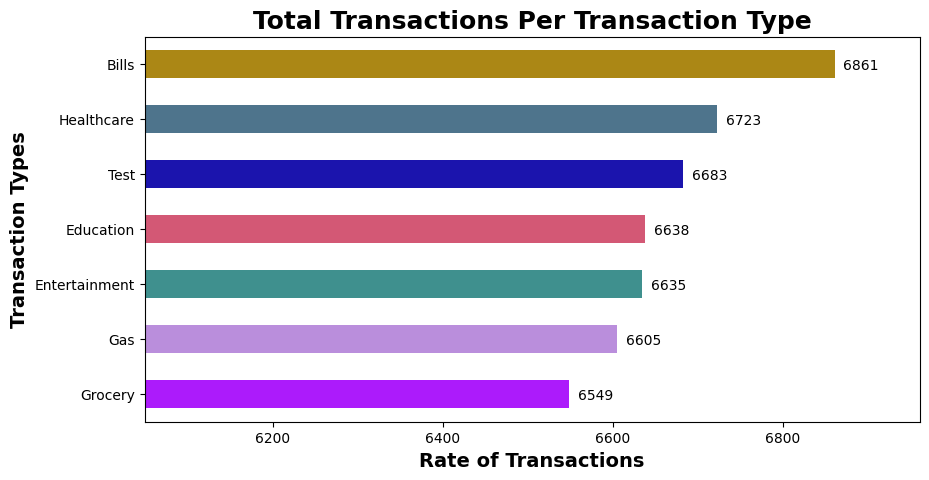

In [192]:
# Function to plot the transaction type that has high rate of transactions.
high_rate_of_tran_by_tran_type(df_tran)

## Functional Requirements 3.2

### Find and plot which state has a high number of customers.
### Note: Take a screenshot of the graphs.

### Function to find and plot which state has a high number of customers.

In [193]:
# Function to find and plot which state has a high number of customers.
def state_with_high_no_of_customers(df_cus):

    # Set random colors for each state.
    state_color = set_colors_for_plot(len(df_cus['CUST_STATE'].unique()))
    
    # Getting the countof the customers per state.
    states = df_cus['CUST_STATE'].value_counts()

    # Set random colors for each state.
    state_color = set_colors_for_plot(len(states))

    states.sort_values(ascending=True, inplace = True)

    # Plotting the bar graph for the states.
    states.plot(kind='barh', figsize=(10, 5), color = state_color)
 
    # Setting the title.
    plt.title('Total Number of Customers Per State', fontweight = 'bold', fontsize = '18')
    # Setting the x-label.
    plt.xlabel('Total Number of Customers', fontweight = 'bold', fontsize = '14')
    # Setting the y-label.
    plt.ylabel('Customers State', fontweight = 'bold', fontsize = 14)

    # Displaying the number of customers for the state.
    for index, value in enumerate(states): 
      plt.text(value+0.6, index-0.4, str(value))
  
    plt.show() 



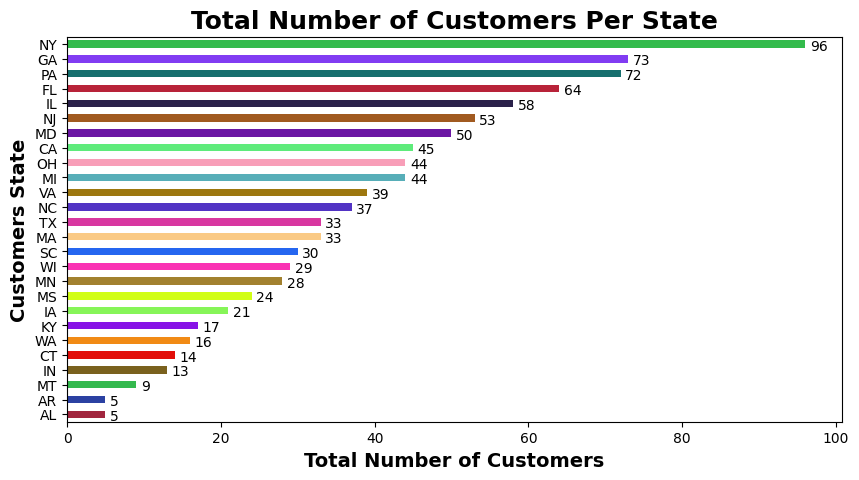

In [199]:
# Function to find and plot which state has a high number of customers.
state_with_high_no_of_customers(df_cus)

## Functional Requirements 3.3

### Find and plot the sum of all transactions for the top 10 customers,
### and which customer has the highest transaction amount.
### hint(use CUST_SSN).
### Note: Take a screenshot of the graphs.

### Function to plot the sum of all transactions for the top 10 customers,
### and which customer has the highest transaction amount.

In [200]:
# Function to plot the sum of all transactions for the top 10 customers,
# and which customer has the highest transaction amount.
# hint(use CUST_SSN).
def highest_and_sum_of_transactions_for_top10(df_customer_cc):

    # Getting the top 10 customers.
    top10 = df_customer_cc.groupby('CUST_SSN')['TRANSACTION_VALUE'].sum().sort_values().tail(10)
    # Setting the color for each customer in top 10.
    top10_colors = set_colors_for_plot(len(top10))

    # Plotting the graph for the top 10 customers having the highest total values of transactions.
    top10.plot(kind='barh', figsize=(10, 5), xlim=(top10.min()-200, top10.max()+100), color=top10_colors)

    # Placing text i.e. sum of all transactions at the end of bar
    for index, value in enumerate(top10): 
        plt.text(value+10, index-0.25, '$'+str(value))
     
    # Setting the plot.
    plt.title('Top 10 Total Transaction Amounts Per Customer', fontweight = 'bold', fontsize = 18)
    # Setting the x-label.
    plt.xlabel('Total Transaction Amount', fontweight = 'bold', fontsize = 14)
    # Setting the y-label.
    plt.ylabel('Account Number', fontweight = 'bold', fontsize = 14)
    
    plt.show()

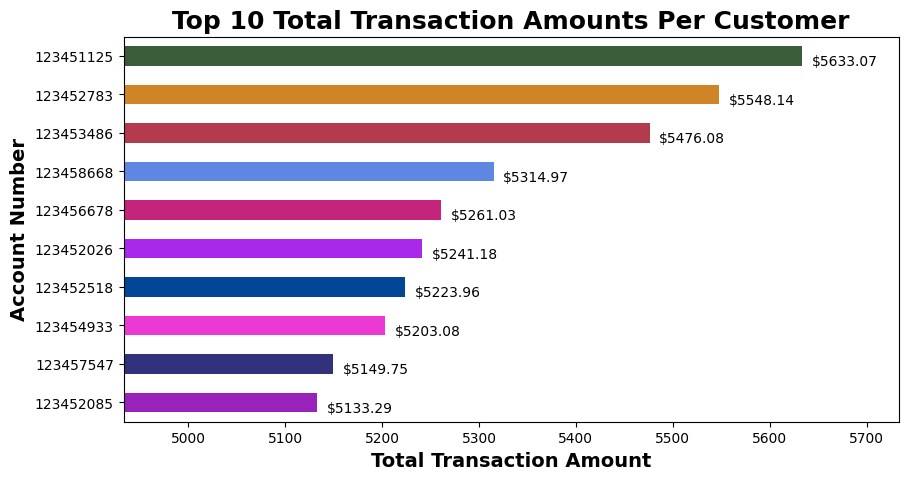

In [203]:
# Function to plot the sum of all transactions for the top 10 customers,
# and which customer has the highest transaction amount.
highest_and_sum_of_transactions_for_top10(df_customer_cc)